## Проект телекоммуникации.
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Цель проекта:
Научится прогнозировать отток клиентов.

Задача проекта:
1) Подготовить данные.
2) Провести исследовательский анализ данных.
3) Построить и обучить модель для прогнозирования оттока клиентов.
4) Добится минимального порога: AUC-ROC = 0.85

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge lightgbm

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install -c conda-forge catboost

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from sklearn.pipeline import make_pipeline, Pipeline 
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool , cv
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore")
# Доимпортировали

In [7]:
import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

%matplotlib inline

In [8]:
contract = pd.read_csv('contract_new.csv')
personal = pd.read_csv('personal_new.csv')
internet = pd.read_csv('internet_new.csv')
phone = pd.read_csv('phone_new.csv')

In [9]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Text(0.5, 1.0, 'Пол клиента')

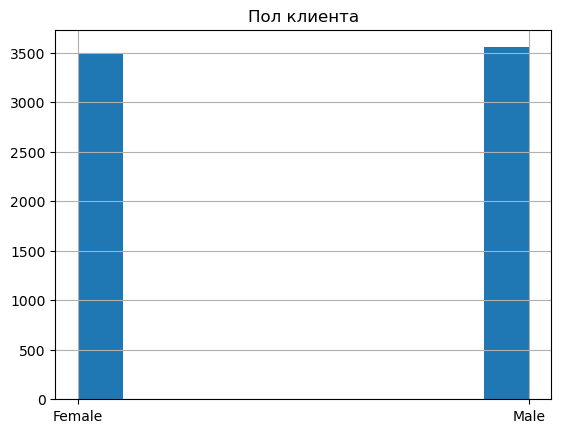

In [12]:
personal['gender'].hist()
plt.title('Пол клиента')

Пользователей женщин и мужчин примерно равное количество

Text(0.5, 1.0, 'Пенсионера')

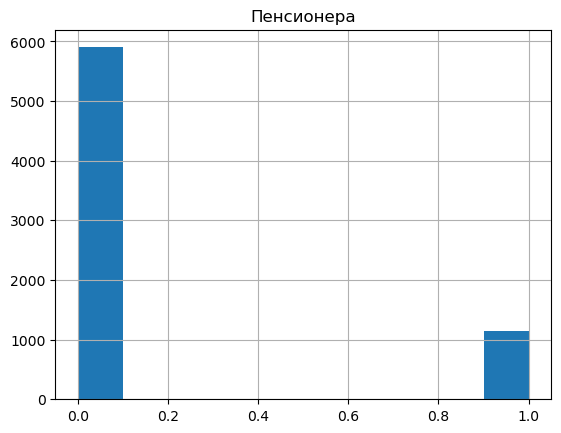

In [13]:
personal['SeniorCitizen'].hist()
plt.title('Пенсионера')

Пользователей имеющих статус пенсионеров подавляющее меньшенство

Text(0.5, 1.0, 'Наличие партнера')

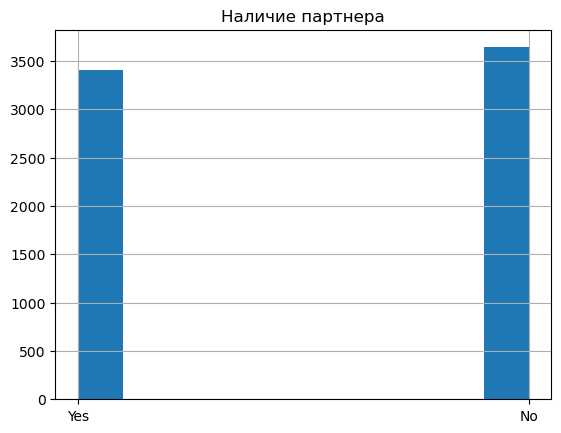

In [14]:
personal['Partner'].hist()
plt.title('Наличие партнера')

Клиентов с партёром и без практически одинаковое количество

Text(0.5, 1.0, 'Наличие иждевенца')

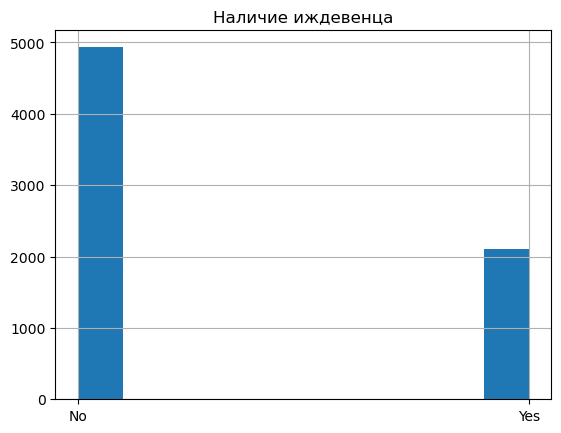

In [15]:
personal['Dependents'].hist()
plt.title('Наличие иждевенца')

Клиентов с детьми почти треть от общего количества

<div class="alert alert-success">
<b>👍 Успех:</b> Датасет исследован, визуализировано распределение данных
</div>

In [16]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [17]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


OnlineSecurity 
 OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64


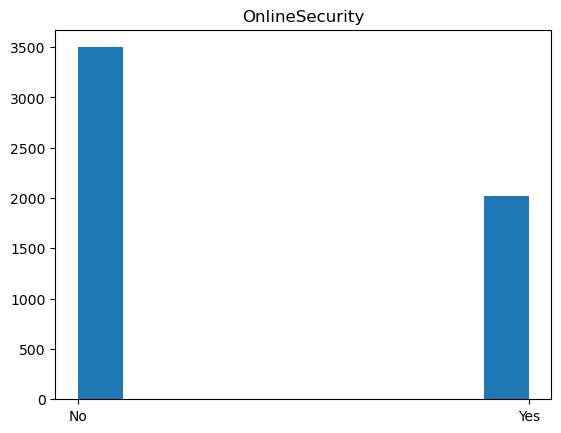

OnlineBackup 
 OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64


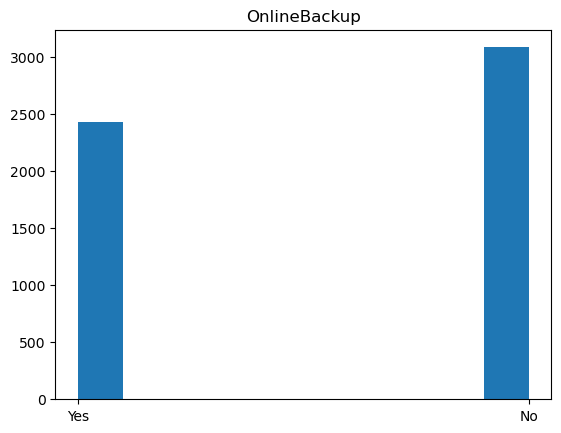

DeviceProtection 
 DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64


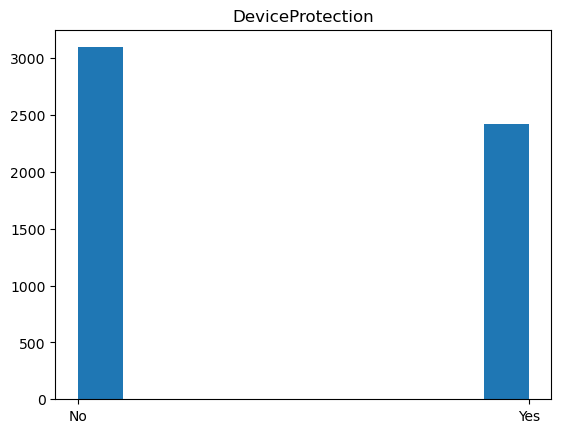

TechSupport 
 TechSupport
No     3473
Yes    2044
Name: count, dtype: int64


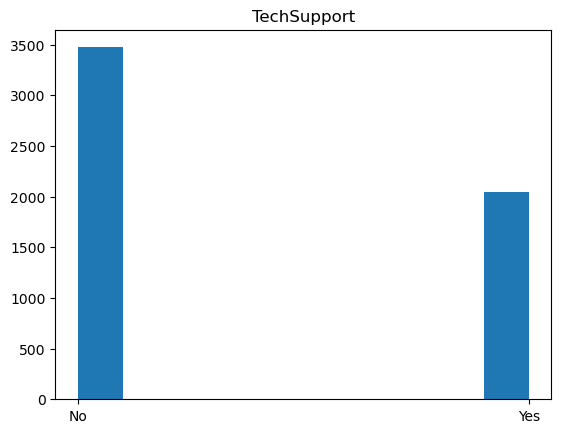

StreamingTV 
 StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64


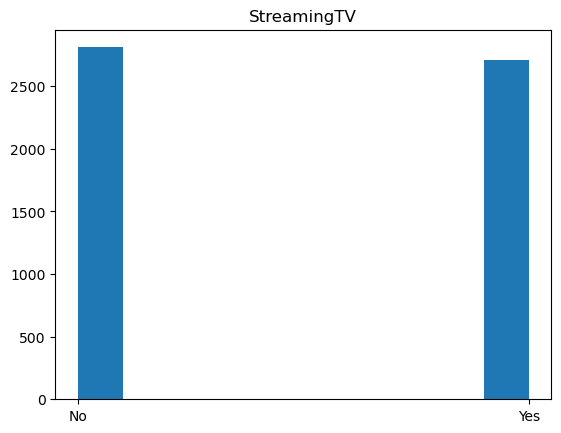

StreamingMovies 
 StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64


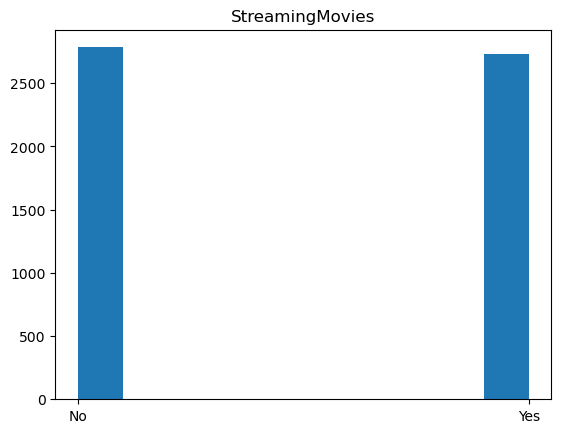

In [19]:
binary = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for i in binary:
    print(i,'\n',internet[i].value_counts())
    plt.hist(internet[i])
    plt.title(i)
    plt.show()

Text(0.5, 1.0, 'Тип подключения')

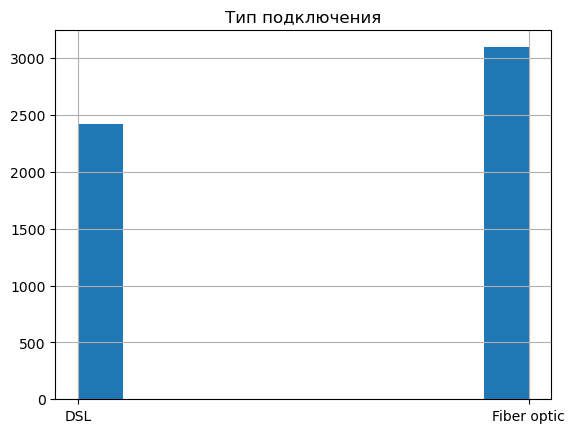

In [20]:
internet['InternetService'].hist()
plt.title('Тип подключения')

Тут для построения графиков применил цикл: 
1 - пользователей онлайн блокировкой сайтов на треть меньше
2 - Пользователей хранилищем почти поровну (удивительно)
3 - Пользователей антивирусом на 500 человек меньше
4 - выделеной техподдержкой пользуются 2000 тысячи человек
5 - пользователей стриминго ТВ поровну от всех клиентов
6 - Подключений по DSL немногим меньше чем по оптоволокну

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [21]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Text(0.5, 1.0, 'Многоканальный телефон')

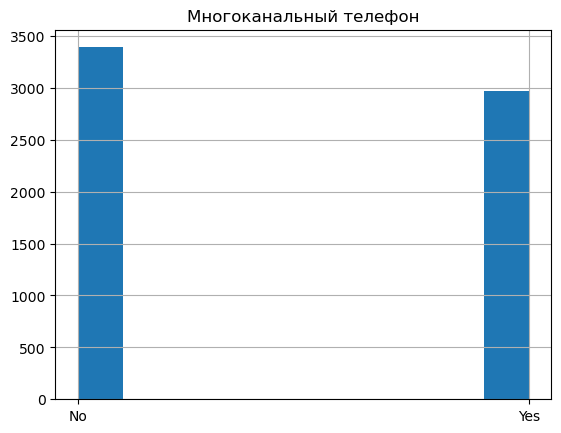

In [23]:
phone['MultipleLines'].hist()
plt.title('Многоканальный телефон')

Многоканальным телефоном пользуется чуть меньше людей чем обычным

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


Text(0.5, 1.0, 'Оплата услуг')

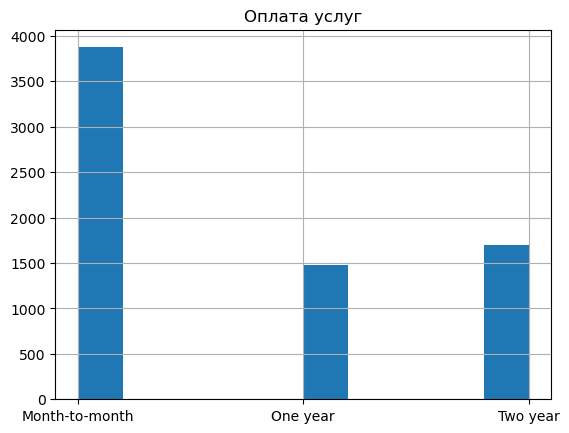

In [24]:
print(contract['Type'].value_counts())
contract['Type'].hist()
plt.title('Оплата услуг') # посмотрим на какие сроки клиенты оплачивают услуги

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


Text(0.5, 1.0, 'Способ оплаты')

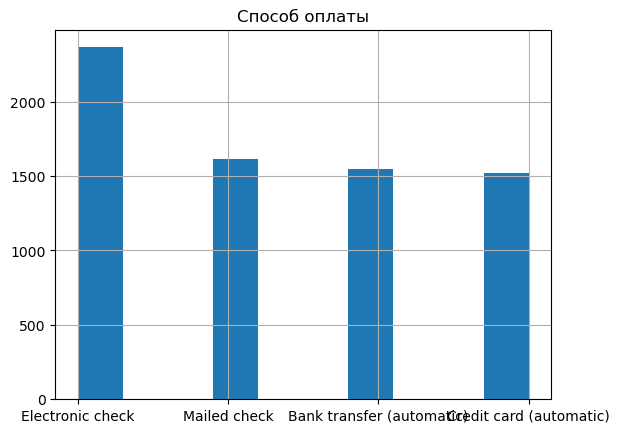

In [25]:
print(contract['PaymentMethod'].value_counts())
contract['PaymentMethod'].hist()
plt.title('Способ оплаты')# посмотрим какими способами клиенты производят оплату

In [26]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate']) # преобразуем даты

In [27]:
contract['NotClient'] = (contract['EndDate'] != 'No').astype(int) # добавим столбец с целевым признаком 

In [28]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [29]:
contract['NotClient'].value_counts()

NotClient
0    5942
1    1101
Name: count, dtype: int64

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Целевой признак добавлен
</div>

In [30]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'].replace(['No'], ['2020-02-01']))

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Почему заменяешь данные на такую дату? </s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Изначально поставил текущую дату, исправил на 2020-02-01 как указано в описании данных.</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [31]:
contract['Days'] = (contract['EndDate'] - contract['BeginDate']).dt.days #

In [32]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


<Axes: >

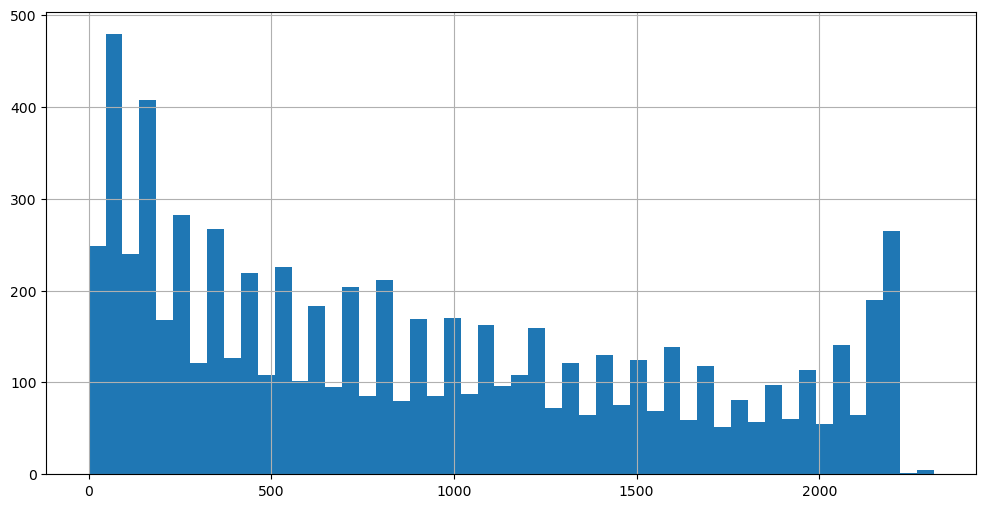

In [33]:
contract['Days'].hist(bins=50, figsize=(12,6))

<Axes: >

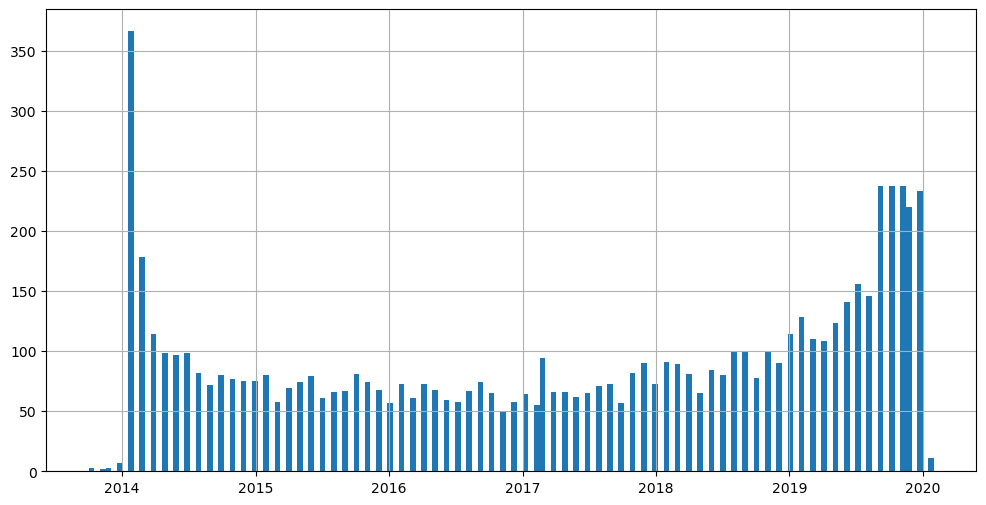

In [34]:
contract['BeginDate'].hist(bins=150, figsize=(12,6))

In [35]:
contract.isnull().sum() # Смотрим пропуски

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
NotClient           0
Days                0
dtype: int64

In [36]:
contract = contract.drop(['BeginDate','EndDate'], axis=1) # удалим столбцы с датами чтобы избежать утечку

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Эти данные нам больше не нужны
</div>

Вывод:
1 contract - Пропусков в данных нет, из последнего графика распределения по количеству дней подключения пользователей мы видим большие пики в районе 1500 и 3500 дней! Видимо были большие рекламные компании и много людей подключилось к Компании.
Построив график по датам подключения увидим пики появившихся новых пользователей в 2014 и 2020 г.
2 personal - тут стоит отметить что пенсионеров много меньше от общего количества, что закономерно. Наличие иждевенца - пользователей с детьми почти треть от общего количества. 
3 internet - пользователей онлайн блокировкой сайтов и антивирусом на треть меньше, пользователей хранилищем почти поровну (удивительно).
4 phone - пользователей многоканальным телефоном равное количиство

Список уточняющих вопросов - ВОПРОСОВ НЕ ИМЕЮ

Примерный план решения задачи:

1 - предобработка данных и исследовательский анализ.
2 - создание дополнительного признака.
3 - сбор данных в одну таблицу, создание выборок.
4 - применение моделей обучения CatBoost, LightGBM, LogisticRegression.
5 - определить лучшую модель подбирая гиперпараметры и метрику AUC-ROC
6 - тестирование лучшей модели, написание итогового вывода.

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> План должен быть более подробным </s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> добавил пункт 5, 4-ый расписал подробнее.</div>

Цель: Построить модель для прогнозирования оттока клиентов.

<div class="alert alert-success">
<b>👍 Успех:</b> План принят!
</div>

Собераем финальный дата сет, на котором будем обучать наши модели!

In [37]:
data = contract.merge(personal, 
                      how = 'left', on = 'customerID').merge(internet, 
                      how = 'left', on = 'customerID').merge(phone, how = 'left', on = 'customerID')
# обьединим все наши данные в одну таблицу

In [38]:
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   NotClient         7043 non-null   int64  
 7   Days              7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Датасеты объединены, все данные на месте
</div>

In [40]:
data.duplicated().sum() #проверим на наличие дубликатов

0

In [41]:
data = data.fillna('No') # убераем пропуски в столбцах

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   NotClient         7043 non-null   int64  
 7   Days              7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Сколько у нас пропусков, откуда они появились и почему принято решение о такой замене?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Пропуски появились после обьединения данных, в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines. Появились потому что люди не пользуются этими услугами, поэтому и заменил на значение "NO".</div> 

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Значение No используется если не подключена конкретная услуга, но подключен интерент или телефон. Заполнение всех пропусков этим значением не даст различий между этими данными
</div>

In [43]:
data.isna().mean()

customerID          0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
NotClient           0.0
Days                0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
MultipleLines       0.0
dtype: float64

In [44]:
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [45]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Days']

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   NotClient         7043 non-null   int64  
 7   Days              7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [47]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   NotClient         7043 non-null   int64  
 7   Days              7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Что получилось в результате такой замены?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Использовал метод to_numeric() с параметром errors='coerce', для преобразованият значений типа object в float64.</div> 

In [49]:
data[numeric].corr()

,MonthlyCharges,TotalCharges,Days
MonthlyCharges,1.000000,0.630297,0.220054
TotalCharges,0.630297,1.000000,0.821442
Days,0.220054,0.821442,1.000000


Между признаками TotalCharges и Days сильная корреляция, 0.82, присутствует проблему мультиколлинеарности. Это объясняется тем, что чем дольше клиент пользуется услугами, тем больше составляют его общие расходы. 
Далее поработаем с признаками и добавим кореляцию по всем.

In [50]:
data.InternetService.unique() 

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [51]:
def coding_for_binary_features(data, binary):
    data[binary].fillna(0, inplace = True) # пропуск соответствует значению "No"
    data[binary] = data[binary].replace(['No'], 0)
    data[binary] = data[binary].replace(['Yes'], 1)
    return data[binary]

In [52]:
data['MultipleLines'] = coding_for_binary_features(data, 'MultipleLines')
#data['InternetService'] = coding_for_binary_features(data, 'InternetService')
data['OnlineSecurity'] = coding_for_binary_features(data, 'OnlineSecurity')
data['OnlineBackup'] = coding_for_binary_features(data, 'OnlineBackup')
data['DeviceProtection'] = coding_for_binary_features(data, 'DeviceProtection')
data['TechSupport'] = coding_for_binary_features(data, 'TechSupport')
data['StreamingTV'] = coding_for_binary_features(data, 'StreamingTV')
data['StreamingMovies'] = coding_for_binary_features(data, 'StreamingMovies')

In [53]:
data['Partner'] = coding_for_binary_features(data, 'Partner')
data['Dependents'] = coding_for_binary_features(data, 'Dependents')

In [54]:
data['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [55]:
data['gender'] = data['gender'].replace(['Male'], 1).replace(['Female'], 0)
data['PaperlessBilling'] = data['PaperlessBilling'].replace(['Yes'], 1).replace(['No'], 0)

#data['InternetService'] = data['InternetService'].replace(['DSL'], 1).replace(['Fiber optic'], 0)

In [56]:
data['InternetService'] = data['InternetService'].replace(['No'], 'no_internet')


In [57]:
data['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
no_internet    1526
Name: count, dtype: int64

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   int64  
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   NotClient         7043 non-null   int64  
 7   Days              7043 non-null   int64  
 8   gender            7043 non-null   int64  
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   int64  
 11  Dependents        7043 non-null   int64  
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   int64  
 14  OnlineBackup      7043 non-null   int64  
 15  DeviceProtection  7043 non-null   int64  
 16  TechSupport       7043 non-null   int64  


 <div class="alert alert-danger">
 <b>😔 Необходимо исправить V3:</b>  А если добавиться еще какой то тип подключения? Нужно заполнить пропуски заглушкой, например "no_internet", а после разделения на выборки закодировать этот признак
 </div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b>  Заполнил пропуски заглушкой "no_internet", а после разделения на выборки закодировал признак. </div> 

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить V2:</b> InternetService не бинарный признак, там 2 значения типа подключения и No при отсутствии подключения. Нельзя заменять на 0 2 разных значения</s>
</div>

In [59]:
data['TotalCharges'].value_counts()

TotalCharges
20.45      6
101.00     5
21.53      4
1007.50    4
732.60     4
          ..
4357.50    1
3509.55    1
2530.80    1
2599.10    1
7251.82    1
Name: count, Length: 6657, dtype: int64

In [60]:
null_data = data[data['TotalCharges'].isnull()]
null_data


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,Two year,1,Bank transfer (automatic),52.55,NaN,0,0,0,0,1,1,DSL,1,0,1,1,1,0,0
753,3115-CZMZD,Two year,0,Mailed check,20.25,NaN,0,0,1,0,0,1,no_internet,0,0,0,0,0,0,0
936,5709-LVOEQ,Two year,0,Mailed check,80.85,NaN,0,0,0,0,1,1,DSL,1,1,1,0,1,1,0
1082,4367-NUYAO,Two year,0,Mailed check,25.75,NaN,0,0,1,0,1,1,no_internet,0,0,0,0,0,0,1
1340,1371-DWPAZ,Two year,0,Credit card (automatic),56.05,NaN,0,0,0,0,1,1,DSL,1,1,1,1,1,0,0
3331,7644-OMVMY,Two year,0,Mailed check,19.85,NaN,0,0,1,0,1,1,no_internet,0,0,0,0,0,0,0
3826,3213-VVOLG,Two year,0,Mailed check,25.35,NaN,0,0,1,0,1,1,no_internet,0,0,0,0,0,0,1
4380,2520-SGTTA,Two year,0,Mailed check,20.00,NaN,0,0,0,0,1,1,no_internet,0,0,0,0,0,0,0
5218,2923-ARZLG,One year,1,Mailed check,19.70,NaN,0,0,1,0,1,1,no_internet,0,0,0,0,0,0,0
6670,4075-WKNIU,Two year,0,Mailed check,73.35,NaN,0,0,0,0,1,1,DSL,0,1,1,1,1,0,1


In [61]:
data['MonthlyCharges'] = data['MonthlyCharges'].astype('int')
data['TotalCharges'] = data['TotalCharges'].replace([' '], 0)
data['TotalCharges'] = data['TotalCharges'].fillna(0).astype('int')

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить V2:</b> Как было принято решение о заполнении пропусков в TotalCharges? нужно сначала посмотреть на эти данные и понять причину пропусков</s>
</div>

In [62]:
null_data = data[data['TotalCharges'].isnull()]
null_data 

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Вывел строки с пропусками 'TotalCharges' их всего 11. мне кажется замена на ноль не повлияет на итоговое решение. </div> 

 <div class="alert alert-danger">
 <b>😔 Необходимо исправить V3:</b> Замена на 0 верный вариант, но почему в этих строках возникли пропуски? Что это за клиенты? Почему у них нет никаких расходов?
 </div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Можно предположить что это клиенты которые только подключились к провайдеру, но ещё не оплачивали услуги. </div> 

In [63]:
data.info()
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   Type              7043 non-null   object
 2   PaperlessBilling  7043 non-null   int64 
 3   PaymentMethod     7043 non-null   object
 4   MonthlyCharges    7043 non-null   int64 
 5   TotalCharges      7043 non-null   int64 
 6   NotClient         7043 non-null   int64 
 7   Days              7043 non-null   int64 
 8   gender            7043 non-null   int64 
 9   SeniorCitizen     7043 non-null   int64 
 10  Partner           7043 non-null   int64 
 11  Dependents        7043 non-null   int64 
 12  InternetService   7043 non-null   object
 13  OnlineSecurity    7043 non-null   int64 
 14  OnlineBackup      7043 non-null   int64 
 15  DeviceProtection  7043 non-null   int64 
 16  TechSupport       7043 non-null   int64 
 17  StreamingTV   

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,1,Electronic check,29,31,0,31,0,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,One year,0,Mailed check,56,2071,0,1036,1,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,Month-to-month,1,Mailed check,53,226,0,123,1,0,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,One year,0,Bank transfer (automatic),42,1960,0,1371,1,0,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,Month-to-month,1,Electronic check,70,353,0,153,0,0,0,0,Fiber optic,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,1,Mailed check,84,2035,0,730,1,0,1,1,DSL,1,0,1,1,1,1,1
7039,2234-XADUH,One year,1,Credit card (automatic),103,7430,0,2191,0,0,1,1,Fiber optic,0,1,1,0,1,1,1
7040,4801-JZAZL,Month-to-month,1,Electronic check,29,325,0,337,0,0,1,1,DSL,1,0,0,0,0,0,0
7041,8361-LTMKD,Month-to-month,1,Mailed check,74,520,0,215,1,1,1,0,Fiber optic,0,0,0,0,0,0,1


In [64]:
corr = data.drop(['customerID', 'Type', 'PaymentMethod', 'InternetService'], axis=1)
corr

,PaperlessBilling,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,1,29,31,0,31,0,0,1,0,0,1,0,0,0,0,0
1,0,56,2071,0,1036,1,0,0,0,1,0,1,0,0,0,0
2,1,53,226,0,123,1,0,0,0,1,1,0,0,0,0,0
3,0,42,1960,0,1371,1,0,0,0,1,0,1,1,0,0,0
4,1,70,353,0,153,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,84,2035,0,730,1,0,1,1,1,0,1,1,1,1,1
7039,1,103,7430,0,2191,0,0,1,1,0,1,1,0,1,1,1
7040,1,29,325,0,337,0,0,1,1,1,0,0,0,0,0,0
7041,1,74,520,0,215,1,1,1,0,0,0,0,0,0,0,1


In [65]:
corr1 = corr.corr(method='pearson')
corr1

,PaperlessBilling,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
PaperlessBilling,1.000000,0.352138,0.153571,0.054869,-0.001569,-0.011754,0.156530,-0.014877,-0.111377,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.163530
MonthlyCharges,0.352138,1.000000,0.630453,0.154373,0.220056,-0.014892,0.220129,0.096913,-0.113910,0.296631,0.441693,0.482646,0.338325,0.629562,0.627421,0.490505
TotalCharges,0.153571,0.630453,1.000000,0.052173,0.821746,-0.010466,0.093987,0.288752,0.053755,0.392793,0.478689,0.494976,0.420213,0.497683,0.494810,0.438421
NotClient,0.054869,0.154373,0.052173,1.000000,0.016578,0.013499,0.056724,0.146447,0.032564,0.085921,0.148288,0.141059,0.067596,0.129261,0.143557,0.169066
Days,-0.001569,0.220056,0.821746,0.016578,1.000000,-0.003825,0.005283,0.339945,0.148731,0.301884,0.318038,0.326907,0.306542,0.256113,0.254143,0.293424
gender,-0.011754,-0.014892,-0.010466,0.013499,-0.003825,1.000000,-0.001874,-0.001808,0.010517,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.008414
SeniorCitizen,0.156530,0.220129,0.093987,0.056724,0.005283,-0.001874,1.000000,0.016479,-0.211185,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.142948
Partner,-0.014877,0.096913,0.288752,0.146447,0.339945,-0.001808,0.016479,1.000000,0.452676,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.142057
Dependents,-0.111377,-0.113910,0.053755,0.032564,0.148731,0.010517,-0.211185,0.452676,1.000000,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,-0.024526
OnlineSecurity,-0.003636,0.296631,0.392793,0.085921,0.301884,-0.017021,-0.038653,0.143106,0.080972,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,0.098108


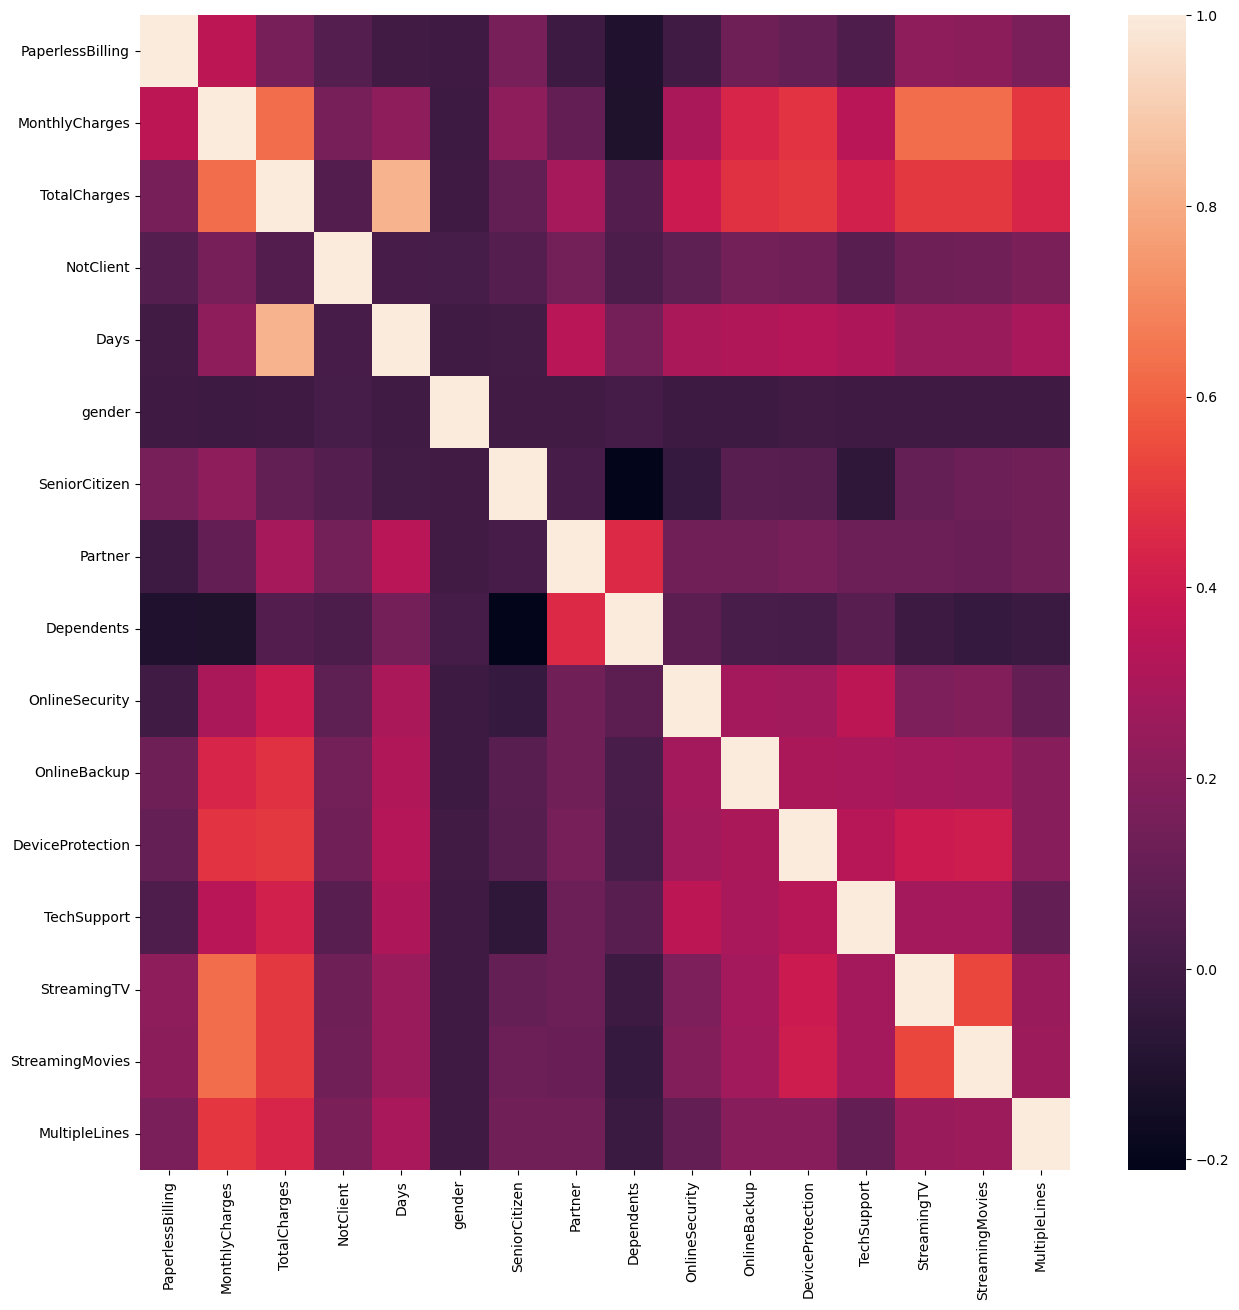

In [66]:
plt.figure(figsize = (15, 15))
sns.heatmap(corr1, annot=False);

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить V2:</b> Корреляция Пирсона не подходит для наших данных, у нас много категориальных данных. Лучше испоьзовать Phik https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7</s>

</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Ниже добавил кореляцию Phik по всем признакам.</div> 

In [67]:
corr2 = data.phik_matrix()
corr2

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'NotClient', 'Days', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Type,1.0,1.000000,0.106860,0.277462,0.390345,0.470275,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498
PaperlessBilling,1.0,0.106860,1.000000,0.370495,0.466732,0.201903,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972
PaymentMethod,1.0,0.277462,0.370495,1.000000,0.401855,0.335855,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313
MonthlyCharges,1.0,0.390345,0.466732,0.401855,1.000000,0.709975,0.227075,0.389881,0.008057,0.305296,0.202279,0.184788,0.918528,0.550428,0.630988,0.669917,0.578023,0.838198,0.833743,0.677054
TotalCharges,1.0,0.470275,0.201903,0.335855,0.709975,1.000000,0.303275,0.848097,0.000000,0.135994,0.382837,0.084325,0.490121,0.521815,0.622455,0.640979,0.549835,0.641866,0.643477,0.573757
NotClient,1.0,0.094015,0.083398,0.214832,0.227075,0.303275,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.261237
Days,1.0,0.634155,0.026799,0.350964,0.389881,0.848097,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.398222
gender,1.0,0.000000,0.000000,0.000000,0.008057,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,1.0,0.086231,0.242133,0.292725,0.305296,0.135994,0.086159,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313


 <div class="alert alert-danger">
 <b>😔 Необходимо исправить V3:</b> Установка модуля и импорт библиотек доблжны быть добавлены в начало работы, в ячейку с импортами (установка модуля до ячейки с импортами)
 </div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил, вынес всё наверх.</div> 

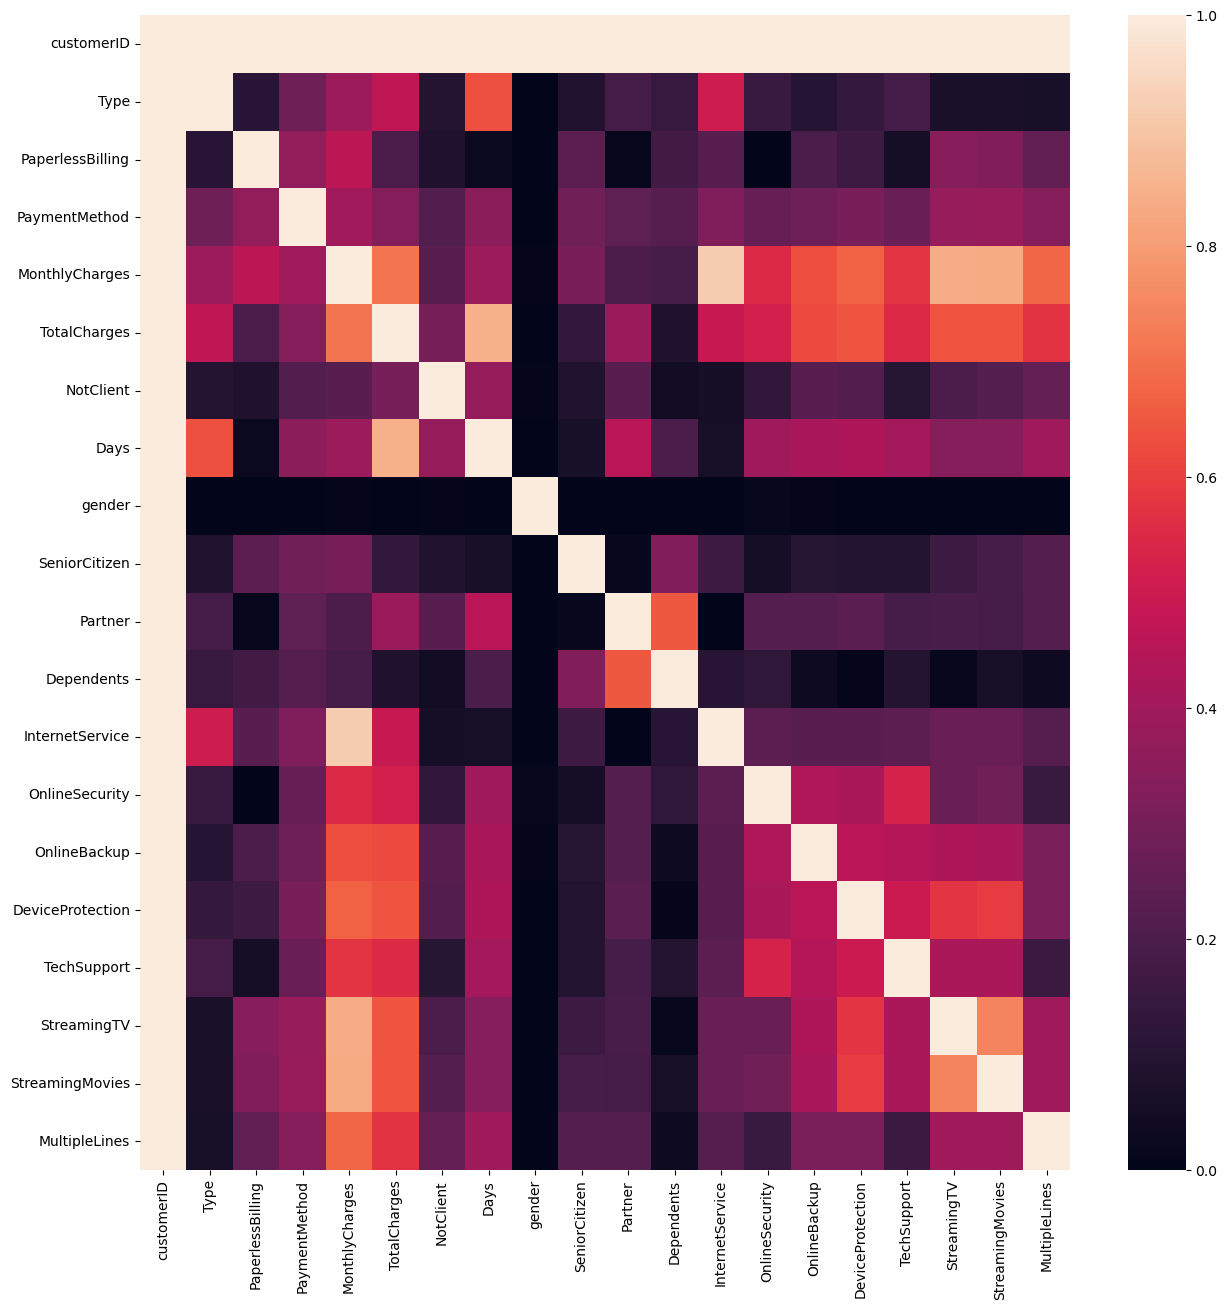

In [68]:
plt.figure(figsize = (15, 15))
sns.heatmap(corr2, annot=False);

более сильную кореляцию имеет зависимость потраченных денег от использованных услуг.

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Все данные нужно исследовать в разрезе ушел/остался, корреляцию нужно посмотреть по всем признакам</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Добавил кореляцию по всем признакам.</div> 

In [69]:
data.info()
# data['gender'] = data['gender'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   Type              7043 non-null   object
 2   PaperlessBilling  7043 non-null   int64 
 3   PaymentMethod     7043 non-null   object
 4   MonthlyCharges    7043 non-null   int64 
 5   TotalCharges      7043 non-null   int64 
 6   NotClient         7043 non-null   int64 
 7   Days              7043 non-null   int64 
 8   gender            7043 non-null   int64 
 9   SeniorCitizen     7043 non-null   int64 
 10  Partner           7043 non-null   int64 
 11  Dependents        7043 non-null   int64 
 12  InternetService   7043 non-null   object
 13  OnlineSecurity    7043 non-null   int64 
 14  OnlineBackup      7043 non-null   int64 
 15  DeviceProtection  7043 non-null   int64 
 16  TechSupport       7043 non-null   int64 
 17  StreamingTV   

## Подготовка данных

Создадим переменные с признаками

In [70]:
data = data.drop(['customerID'], axis=1)
#data = data.drop(['Days'], axis=1)

In [71]:
data.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
NotClient           0
Days                0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Почему принято решение об удалении этих признаков?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Удалил только 'customerID'. </div> 

 <div class="alert alert-danger">
 <b>😔 Необходимо исправить V3:</b> Я вижу удаление столбца 'Days', почему принято решение его удалить?
 </div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Вообщем по итогу 'Days' решил оставить. И с ним CatBoost на тесте получилось = 0.92 </div> 

In [72]:
features = data.drop(['NotClient'], axis=1)
target = data['NotClient']

Создадим тренироваочный и тестовые датасеты

In [73]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=250923)

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Нужно проверить, что данные корректно разделились на выборки</s>
</div>

In [74]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5282, 18), (5282,), (1761, 18), (1761,))

In [75]:
features_train.dtypes

Type                object
PaperlessBilling     int64
PaymentMethod       object
MonthlyCharges       int64
TotalCharges         int64
Days                 int64
gender               int64
SeniorCitizen        int64
Partner              int64
Dependents           int64
InternetService     object
OnlineSecurity       int64
OnlineBackup         int64
DeviceProtection     int64
TechSupport          int64
StreamingTV          int64
StreamingMovies      int64
MultipleLines        int64
dtype: object

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Данные разделились корректно.</div> 

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить V2:</b> Что в ячейке выше?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Удалил код из ячейки выше.</div> 

Кодируем и стандартизируем признаки для логистической регрессии и случайного леса.

In [76]:
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents',
             'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'MultipleLines', 'InternetService']
num_cols = ['MonthlyCharges', 'Days' , 'TotalCharges']


In [77]:
features_train[features_train.columns.intersection(cat_cols)]

,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1634,Two year,0,Electronic check,0,1,1,DSL,1,1,1,0,1,1,0
6889,Month-to-month,1,Mailed check,0,0,0,Fiber optic,0,0,1,1,1,0,0
6630,Month-to-month,1,Electronic check,1,0,0,Fiber optic,0,0,0,0,0,1,0
4261,One year,1,Mailed check,0,0,0,DSL,0,1,0,1,0,0,0
6785,Two year,1,Credit card (automatic),0,0,0,Fiber optic,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,Month-to-month,1,Electronic check,0,0,0,Fiber optic,0,0,0,1,1,1,1
3840,Two year,0,Credit card (automatic),1,1,0,no_internet,0,0,0,0,0,0,1
935,Month-to-month,1,Electronic check,1,1,0,Fiber optic,0,0,0,0,1,0,1
4395,Month-to-month,1,Electronic check,0,1,1,Fiber optic,0,1,1,0,1,1,1


In [78]:
transformer_log = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='error'), cat_cols),
    (StandardScaler(), num_cols))

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить V2:</b> TotalCharges тоже числовой признак</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Добавил TotalCharges.</div> 

## Логистическая регрессия

In [79]:
model_lr = LogisticRegression(class_weight = 'balanced', random_state = 250923)

In [80]:
features_train.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Days                0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Проверь еще раз работу моделей, какие предупреждения и ошибки появляются при их работе, какое значение метрики, нет ли утечки. Во всех моделях лучше использовать GridSearchCV.</s>
</div>

In [81]:
pipline_lr = make_pipeline(transformer_log, model_lr)
parametrs_lr = { 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__max_iter': range (6,15,2),
              }
lr = GridSearchCV(pipline_lr, param_grid=parametrs_lr, cv=3, scoring='roc_auc')
lr.fit(features_train, target_train)
auc_roc_lr = lr.best_score_
auc_roc_lr_params=lr.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_lr}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_lr_params}')

best_score: 0.7581843806700758
best_params: {'logisticregression__C': 1, 'logisticregression__max_iter': 14}


best_score: 0.7521481401436562
best_params: {'logisticregression__C': 100, 'logisticregression__max_iter': 14}

### Случайный лес

In [82]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state = 250923)
pipline_rf =  make_pipeline(transformer_log, model_rf)
grid = {'randomforestclassifier__n_estimators':[10,20,30,40,50,60,70,80,90,100],
        'randomforestclassifier__max_depth': [5,6,7,8,9]}
rf = lr = GridSearchCV(pipline_rf, param_grid=grid, cv=3, scoring='roc_auc')
rf.fit(features_train, target_train)
auc_roc_rf = rf.best_score_
auc_roc_rf_params=rf.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_rf}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_rf_params}')

best_score: 0.8138120635678942
best_params: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 90}


### Градиентный бустинг CatBoost

In [83]:
train_dataset = Pool(features_train, target_train, cat_features=cat_cols) 
test_dataset = Pool(features_test, target_test, cat_features=cat_cols)
model_cat = CatBoostClassifier(random_state=250923, verbose=200, 
                               eval_metric='AUC:hints=skip_train~false', auto_class_weights = 'Balanced')
grid_cat = {'iterations': [100, 150, 200, 300],
        'depth': [2, 4, 6, 8],
         'l2_leaf_reg': [3,5,7,9] }
model_cat.grid_search(grid_cat, train_dataset, cv=3)

model_cat_auc = model_cat.get_best_score()
print(model_cat_auc)

0:	learn: 0.6863576	test: 0.7085141	best: 0.7085141 (0)	total: 59.8ms	remaining: 5.92s
99:	learn: 0.8222164	test: 0.8419573	best: 0.8419573 (99)	total: 349ms	remaining: 0us

bestTest = 0.8419572553
bestIteration = 99

0:	loss: 0.8419573	best: 0.8419573 (0)	total: 358ms	remaining: 22.6s
0:	learn: 0.6863576	test: 0.7085141	best: 0.7085141 (0)	total: 2.63ms	remaining: 260ms
99:	learn: 0.8221649	test: 0.8411036	best: 0.8411036 (99)	total: 322ms	remaining: 0us

bestTest = 0.8411035674
bestIteration = 99

1:	loss: 0.8411036	best: 0.8419573 (0)	total: 683ms	remaining: 21.2s
0:	learn: 0.6863576	test: 0.7085141	best: 0.7085141 (0)	total: 4.97ms	remaining: 492ms
99:	learn: 0.8217957	test: 0.8411605	best: 0.8413279 (97)	total: 285ms	remaining: 0us

bestTest = 0.8413278697
bestIteration = 97

2:	loss: 0.8413279	best: 0.8419573 (0)	total: 972ms	remaining: 19.8s
0:	learn: 0.6863576	test: 0.7085141	best: 0.7085141 (0)	total: 2.57ms	remaining: 255ms
99:	learn: 0.8233621	test: 0.8418133	best: 0.8419874

In [84]:
model_cat_auc = model_cat.get_best_score()
model_cat_best = model_cat.get_params()
print(model_cat_auc)
print(model_cat_best)

{'learn': {'Logloss': 0.4849443360240337, 'AUC': 0.848066190377278}}
{'verbose': 200, 'auto_class_weights': 'Balanced', 'eval_metric': 'AUC:hints=skip_train~false', 'random_state': 250923, 'depth': 4, 'l2_leaf_reg': 3, 'iterations': 200}


In [85]:
model_cat_auc = model_cat_auc['learn']['AUC']
print(model_cat_auc)

0.848066190377278


### LightGBM

In [86]:
for i in cat_cols:
    features_train[i] = features_train[i].astype('category')
model_lgbm = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=250923) 
grid_lgbm = {'num_leaves':[11, 40],
        'learning_rate': [0.3, 0.4]}
model_lgbm = GridSearchCV(model_lgbm, grid_lgbm, scoring='roc_auc', verbose=10, cv=3)
model_lgbm.fit(features_train, target_train, categorical_feature=cat_cols)
auc_roc_lgbm = model_lgbm.best_score_
auc_roc_lgbm_params=model_lgbm.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_lgbm}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_lgbm_params}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 1/3; 1/4] END learning_rate=0.3, num_leaves=11;, score=0.863 total time=   0.1s
[CV 2/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 2/3; 1/4] END learning_rate=0.3, num_leaves=11;, score=0.897 total time=   0.1s
[CV 3/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 3/3; 1/4] END learning_rate=0.3, num_leaves=11;, score=0.871 total time=   0.1s
[CV 1/3; 2/4] START learning_rate=0.3, num_leaves=40............................
[CV 1/3; 2/4] END learning_rate=0.3, num_leaves=40;, score=0.860 total time=   0.3s
[CV 2/3; 2/4] START learning_rate=0.3, num_leaves=40............................
[CV 2/3; 2/4] END learning_rate=0.3, num_leaves=40;, score=0.886 total time=   0.3s
[CV 3/3; 2/4] START learning_rate=0.3, num_leaves=40............................
[CV 3/3; 2/4] END learning_rate=0.

### Итоговая таблица 

In [87]:
columns=['roc_auc модели', 'парамтеры лучшей модели']
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoost', 'LightGBM']
data = [[auc_roc_lr, auc_roc_lr_params], [auc_roc_rf, auc_roc_rf_params], 
        [model_cat_auc, model_cat_best], [auc_roc_lgbm, auc_roc_lgbm_params]]

final_tabl = pd.DataFrame(data = data, columns = columns, index=index)

In [88]:
final_tabl

,roc_auc модели,парамтеры лучшей модели
LinearRegression,0.758184,"{'logisticregression__C': 1, 'logisticregressi..."
RandomForestRegressor,0.813812,"{'randomforestclassifier__max_depth': 7, 'rand..."
CatBoost,0.848066,"{'verbose': 200, 'auto_class_weights': 'Balanc..."
LightGBM,0.877179,"{'learning_rate': 0.3, 'num_leaves': 11}"


Как мы видим в итоговой таблице лучшей моделью является CatBoost с результатом 0.848066. Далее будем тестировать её в следующем разделе.

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить V2:</b> Значение 0.99 говорит об утечке данных</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Утечка устранена.</div> 

## Тестируем лучшую модель LightGBM

In [89]:
# приводим типы данных в тестовой выборке к обучающей 

features_test['Type'] = features_test['Type'].astype('category')
features_test['PaperlessBilling'] = features_test['PaperlessBilling'].astype('category')
features_test['PaymentMethod'] = features_test['PaymentMethod'].astype('category')
features_test['SeniorCitizen'] = features_test['SeniorCitizen'].astype('category')
features_test['Partner'] = features_test['Partner'].astype('category')
features_test['Dependents'] = features_test['Dependents'].astype('category')
features_test['InternetService'] = features_test['InternetService'].astype('category')
features_test['OnlineSecurity'] = features_test['OnlineSecurity'].astype('category')
features_test['OnlineBackup'] = features_test['OnlineBackup'].astype('category')
features_test['DeviceProtection'] = features_test['DeviceProtection'].astype('category')
features_test['TechSupport'] = features_test['TechSupport'].astype('category')
features_test['StreamingTV'] = features_test['StreamingMovies'].astype('category')
features_test['MultipleLines'] = features_test['MultipleLines'].astype('category')
features_test['StreamingMovies'] = features_test['StreamingMovies'].astype('category')

In [90]:
# Берем наилучшие попраметры для этой модели
params = auc_roc_lgbm_params

# Создаем и тренируем LightGBM модель
model_lgb_best = lgb.LGBMClassifier(**params)
model_lgb_best.fit(features_train, target_train, categorical_feature=cat_cols)

# Предсказываем
predict = model_lgb_best.predict(features_test)

# Вычисляем веротяности прогноза
probabilities_valid = model_lgb_best.predict_proba(features_test,cat_features=cat_cols)
probabilities_one_valid = probabilities_valid[:, 1]

#  ROC-AUC
roc_auc = roc_auc_score(target_test, probabilities_one_valid)

print(roc_auc)

[LightGBM] [Warning] Unknown parameter: cat_features
0.9011794267577186


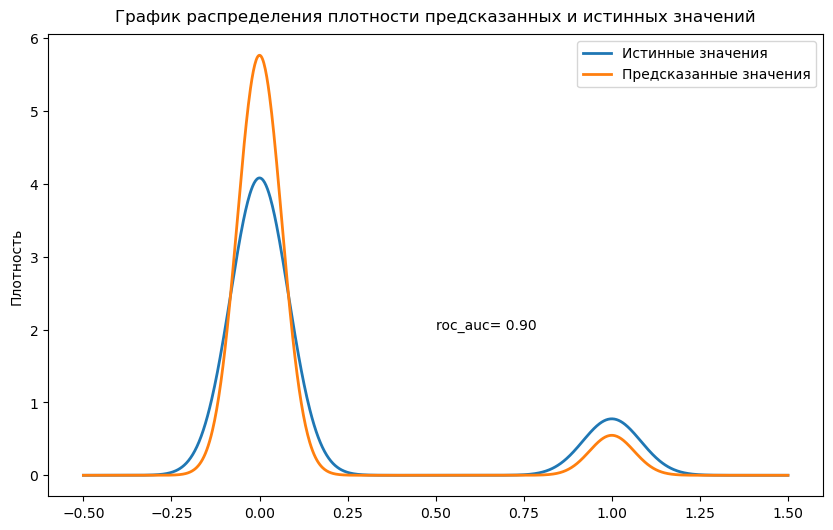

In [91]:
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(predict).plot(kind='kde',linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.text(0.5,2,'roc_auc= {:.2f}'.format(roc_auc))
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

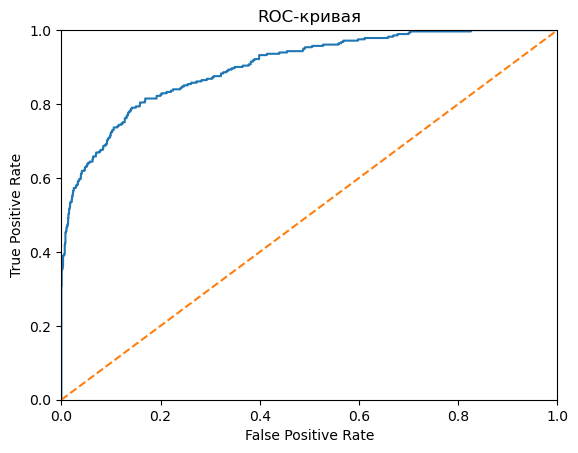

In [92]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_valid[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC-кривая")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

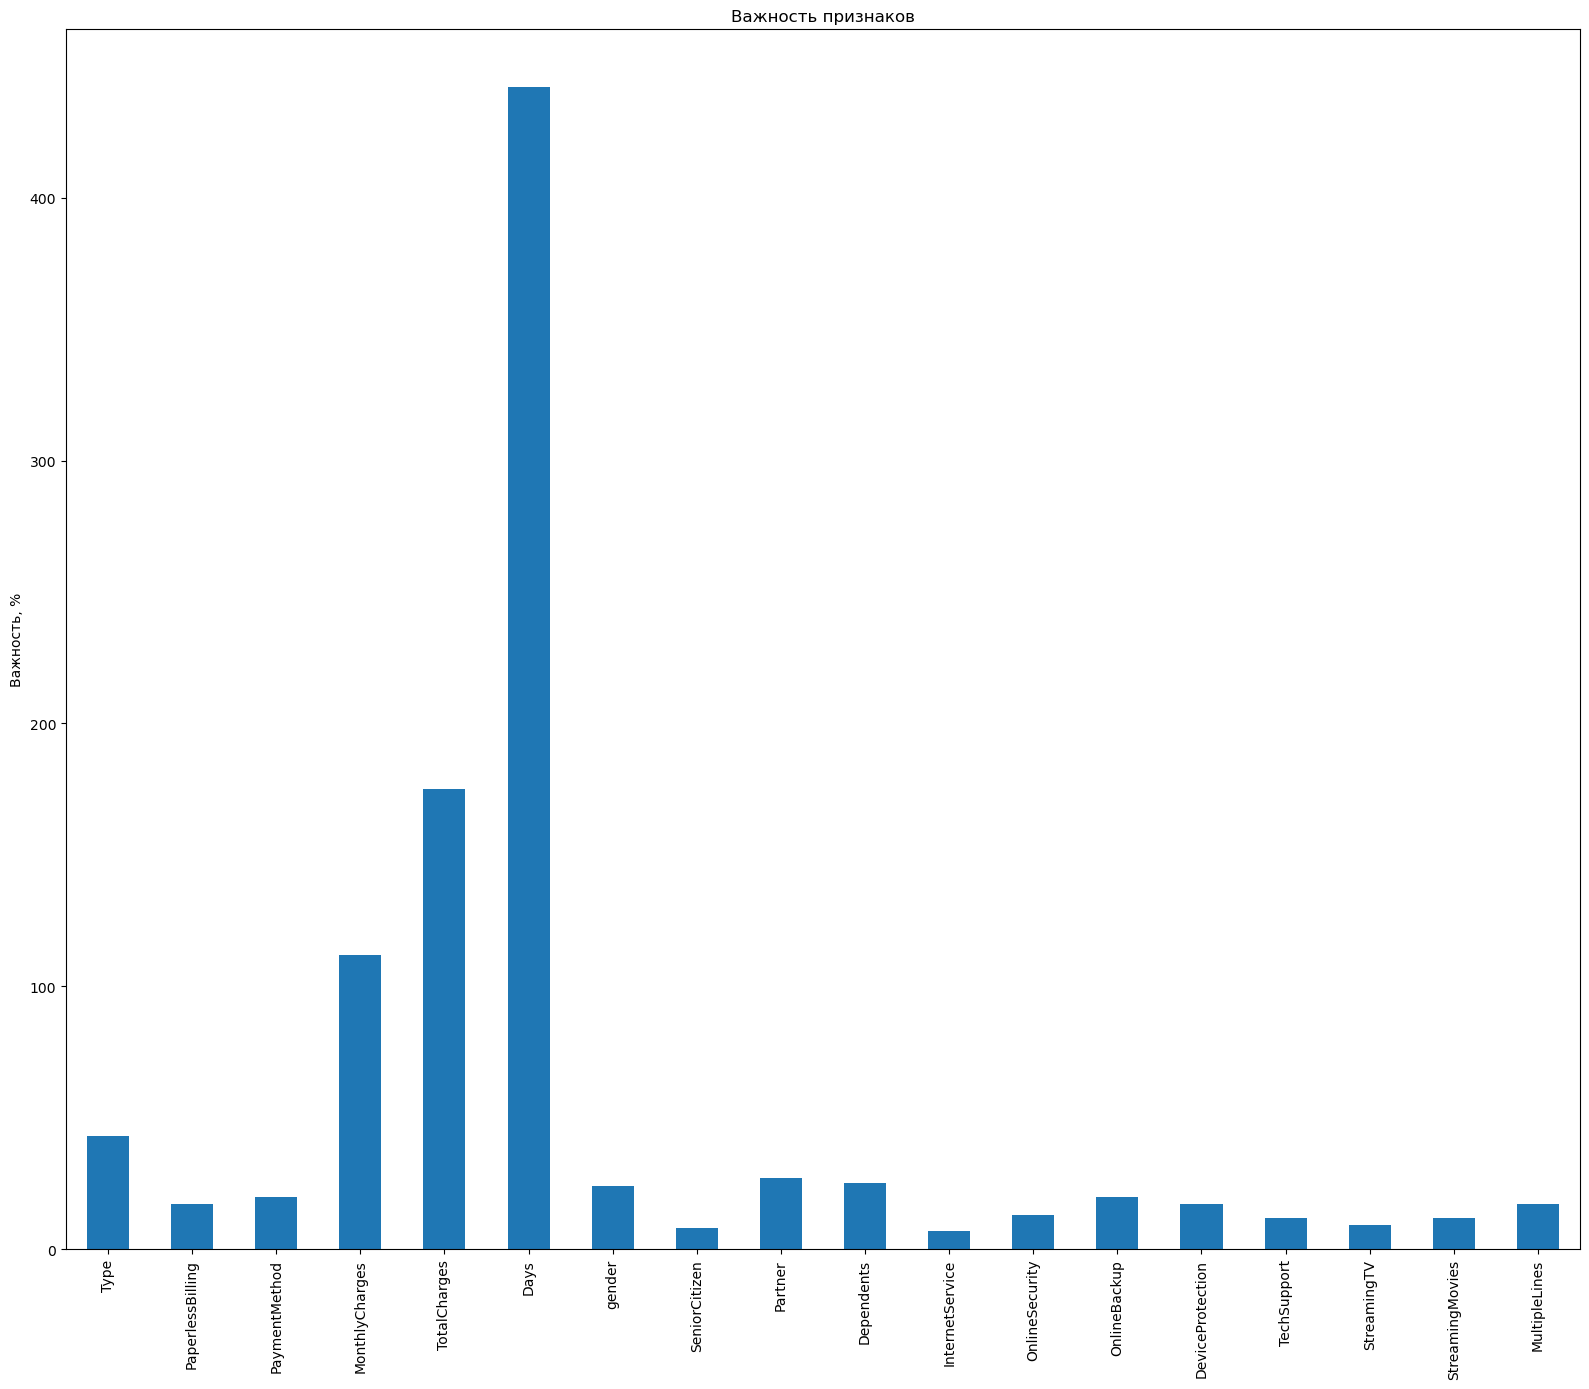

In [93]:
cat_important = pd.Series(model_lgb_best.feature_importances_,
                        features_test.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_important.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Самым важным признаком является количество дней!

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Нужно добавить матрицу ошибок и итоговый вывод, отчет будет в следующей части</s>
</div>

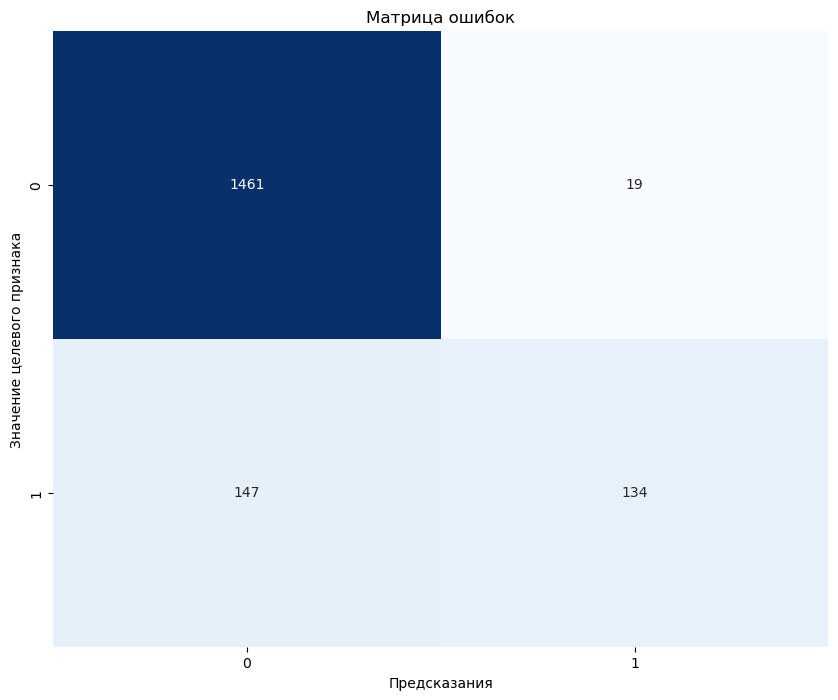

In [94]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_test, predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Значение целевого признака')
plt.show()

Итоговый вывод:
1) Был выполнены предобработка данных и исследовательский анализ, сборка всех датасетов в один, заполнены образовавшиеся пропуски. Детально рассмотрели особенности полученных данных. 2) Создали выборки. 3) Обучили модели 'LinearRegression', 'RandomForestRegressor', 'CatBoost', 'LightGBM', в результате обучения лучше все себя показала модель CatBosst, на ней же была достигнута метрика roc_auc = 0.848066. 4) При тестировании лучшая модель CatBoost показала  результат roc_auc = 0.9. ROC-кривая, построенная по тестовой модели заполняет почти всю площадь графика под кривой, это подтверждает высокое качество модели. 5) Самым важным признаком является количество дней, построили матрицу ошибок она показала 132 ложноотрицательных ошибок и 8 ложноположительных.